In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler
mms = MinMaxScaler()

In [2]:
ref = pd.read_csv('/Users/chan/Downloads/humanbrain_ref.txt',sep='\t',index_col=0)

In [3]:
# bulk = pd.read_csv('/Users/chan/Desktop/pythonProject/ROSMAP/ROSMAP_lengthScaledTPM_counts.txt',
#                    sep='\t',index_col=0)
# bulk = np.log2(bulk+1)
# bulk = pd.DataFrame(mms.fit_transform(bulk).T, index=bulk.columns, columns=bulk.index)

In [4]:
NRGN_bulk = 0.6818290168237499

In [5]:
ori_sigm = ref.groupby('Celltype').sum()
ori_sigm = np.log2(ori_sigm+1)
celltypes = ori_sigm.index
genes = ori_sigm.columns
ori_sigm = pd.DataFrame(mms.fit_transform(ori_sigm.T).T, index=celltypes, columns=genes)

In [6]:
testsigm = pd.read_csv('ROSMAP_overallGEP.csv',index_col=0)
trainsigm = pd.read_csv('ROSMAP_trainGEP.csv',index_col=0)

In [7]:
data = pd.DataFrame(pd.concat([testsigm.loc[celltypes]['NRGN'],ori_sigm['NRGN']]))
data['source'] = ['predicted' for i in range(len(data)//2)] + ['single-cell' for i in range(len(data)//2)]

In [27]:
blue=sns.color_palette('Blues')[4]
red=sns.color_palette('Reds')[4]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


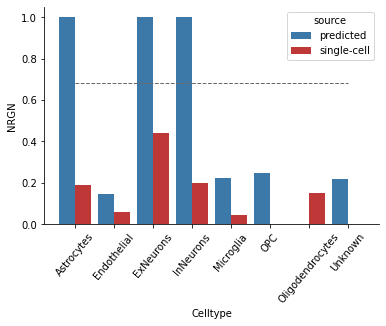

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=data,x=data.index,y='NRGN',hue='source',ax=ax, 
            palette={'predicted':blue,'single-cell':red})
ax.hlines(NRGN_bulk, xmin=0, xmax=7, color='dimgrey',linestyle='dashed', linewidth=1) #画竖水平线
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=50)
fig.savefig('barplot.eps', format='eps', dpi=300)
plt.show()

In [10]:
test_z = pd.DataFrame(scale(testsigm),index=testsigm.index,columns=testsigm.columns)
train_z = pd.DataFrame(scale(trainsigm),index=trainsigm.index,columns=trainsigm.columns)

In [11]:
def select_signature_genes(z_score):
    values = z_score.values
    signature_genes = []
    for i in range(z_score.shape[1]):
        arr = values[:,i]
        idx = arr.argsort()[-2:]
        diff = arr[idx][-1]-arr[idx[-2]]
        if diff >=1.5:
            signature_genes.append(i)
    print(len(signature_genes))
    return z_score.iloc[:,signature_genes]


In [12]:
test_selected = select_signature_genes(test_z)
selected_genes = test_selected.columns
train_selected = train_z[selected_genes]
index = ['InNeurons','Oligodendrocytes','Astrocytes','ExNeurons','Endothelial','Microglia','Unknown','OPC']
test_selected = test_selected.loc[index]
train_selected = train_selected.loc[index]

856


In [13]:
#selected.to_csv('ROSMAP_GEP_ZSCORE.csv')

In [14]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

correlations = test_selected.corr()
correlations_array = np.asarray(test_selected.corr())
np.sum(np.isnan(correlations_array))
row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

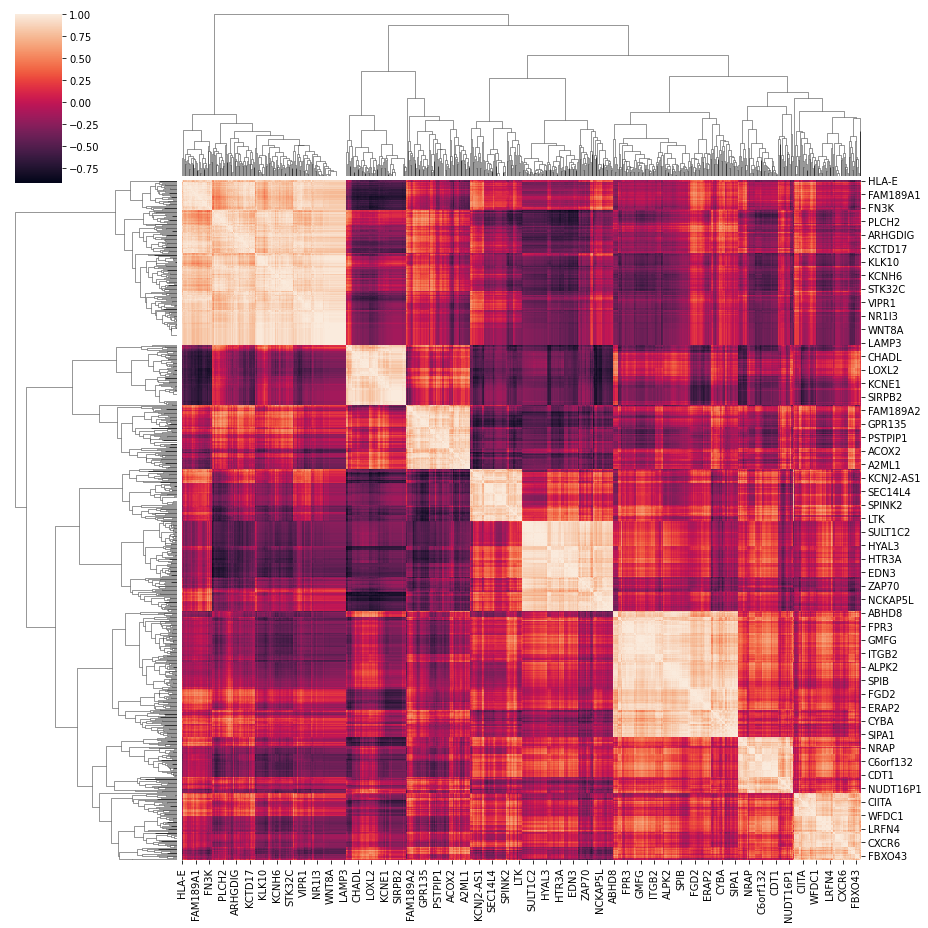

In [15]:
sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage, method="average",
               figsize=(13, 13))

In [16]:
def extract_clustered_table(res, data):
    """
    input
    =====
    res:     <sns.matrix.ClusterGrid>  the clustermap object
    data:    <pd.DataFrame>            input table
    
    output
    ======
    returns: <pd.DataFrame>            reordered input table
    """
    
    if res.dendrogram_col is not None:
        # reordering index and columns
        new_cols = data.columns[res.dendrogram_col.reordered_ind]
        #new_ind = data.index[res.dendrogram_row.reordered_ind]
        
        return data.loc[:,new_cols]

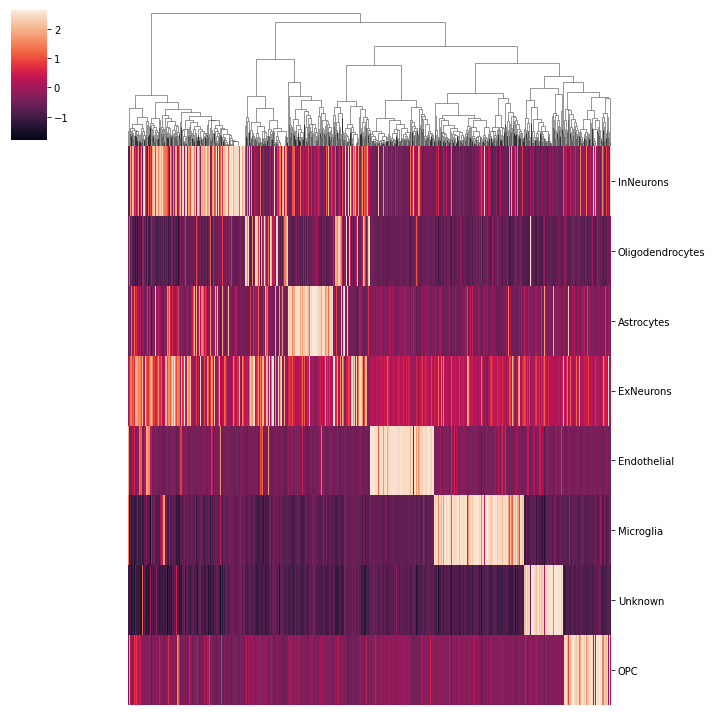

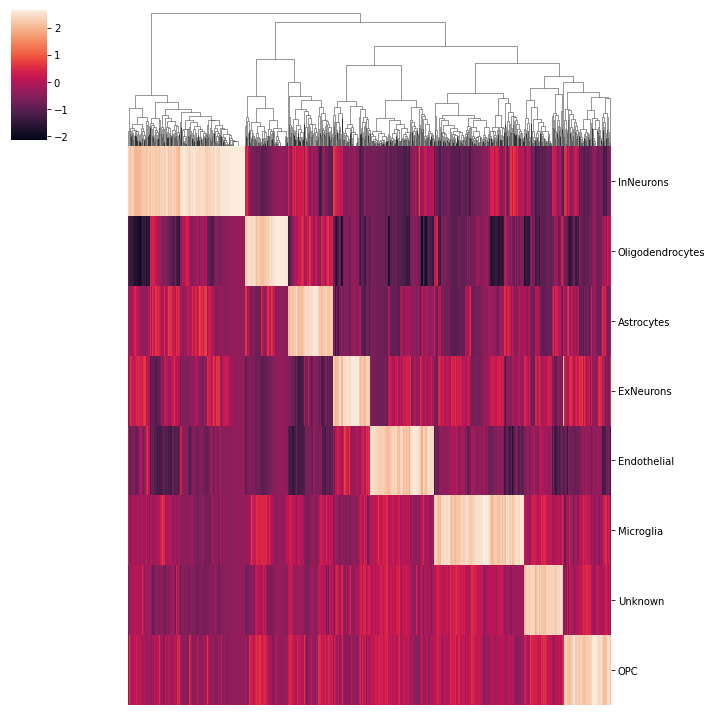

In [17]:
res = sns.clustermap(train_selected, row_cluster=False,col_linkage=col_linkage,
                     xticklabels=False,yticklabels=True)
train_selected = extract_clustered_table(res, train_selected)
res = sns.clustermap(test_selected, row_cluster=False,col_linkage=col_linkage,
                     xticklabels=False,yticklabels=True)
test_selected = extract_clustered_table(res, test_selected)

In [29]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# clist=['blue','orange','red']
# newcmp = LinearSegmentedColormap.from_list('chaos',clist)

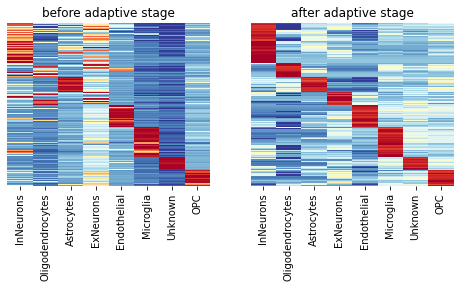

In [45]:
fig, axes = plt.subplots(1,2,figsize=(8,3))
sns.heatmap(train_selected.T,xticklabels=True,yticklabels=False,ax=axes[0],cbar=False,cmap='RdYlBu_r',robust=True)
axes[0].set_title('before adaptive stage')
sns.heatmap(test_selected.T,xticklabels=True,yticklabels=False,ax=axes[1],cbar=False,cmap='RdYlBu_r',robust=True)
axes[1].set_title('after adaptive stage')
# axes[1].set_xticklabels(labels=test_selected.index,rotation=50)
# axes[0].set_xticklabels(labels=train_selected.index,rotation=50)
fig.savefig('GEPchange.eps', format='eps', dpi=300)
plt.show()